# 2D Preprocessing the GlobColour Dataset 
* prepare dataset for LDS-fitting:
   * load all 5 variables and merge (interpolate) with the float dataset
   * load the distance to coast and merge (interpolate) with the float dataset
   * output the data on disk
   * (plan)if needed, split Nov-Dec, encoding the weekly number

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
from dask.diagnostics import ProgressBar
import seaborn as sns
from matplotlib.colors import LogNorm

In [123]:
# resampling frequency in number of days
freq=15

In [3]:
from tools.load_GlobColor_dataset import load_dataset
import importlib
importlib.reload(load_dataset)

<module 'tools.load_GlobColor_dataset.load_dataset' from '/Users/vyan2000/work_linux/2Archive/myproject/20161024xray_oceancolor/ocean_color-master/tools/load_GlobColor_dataset/load_dataset.py'>

100%|██████████| 5538/5538 [01:23<00:00, 66.26it/s]


<xarray.Dataset>
Dimensions:    (lat: 553, lon: 721, time: 5538)
Coordinates:
  * lat        (lat) float32 28.0208 27.9792 27.9375 27.8958 27.8542 27.8125 ...
  * lon        (lon) float32 44.9792 45.0208 45.0625 45.1042 45.1458 45.1875 ...
  * time       (time) datetime64[ns] 2002-04-28 2002-04-29 2002-04-30 ...
Data variables:
    CHL1_mean  (time, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...
Attributes:
    Conventions:                CF-1.4
    title:                      GlobColour daily merged MERIS/SeaWiFS product
    product_name:               L3m_20020428__665648402_4_AVW-MERSWF_CHL1_DAY...
    product_type:               day
    product_version:            2016.1
    product_level:              3
    parameter_code:             CHL1
    parameter:                  Chlorophyll concentration
    parameter_algo_list:        ,
    publication:                O'Reilly, J.E., and 24 Coauthors, 2000: SeaWi...
    site_name:                  665648402
    sensor_name:   

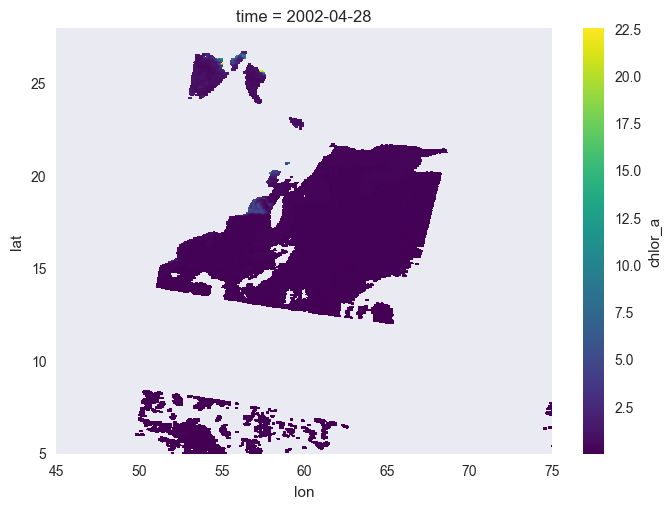

In [5]:
############### CHL1
ds_daily = load_dataset.load_chl1()
ds_daily.chlor_a.sel(time='2002-04-28').plot()

In [6]:
freq_resample = str(8) + 'D'
ds_8day = ds_daily.resample(freq_resample, dim='time')  # see the above for doc, test case, & default behavior
ds_8day

<xarray.Dataset>
Dimensions:  (lat: 553, lon: 721, time: 695)
Coordinates:
  * lat      (lat) float32 28.0208 27.9792 27.9375 27.8958 27.8542 27.8125 ...
  * lon      (lon) float32 44.9792 45.0208 45.0625 45.1042 45.1458 45.1875 ...
  * time     (time) datetime64[ns] 2002-04-28 2002-05-06 2002-05-14 ...
Data variables:
    chlor_a  (time, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...

In [7]:
# check data quality
both_datasets = [ds_8day, ds_daily]
print([(ds.nbytes / 1e6) for ds in both_datasets])

[2216.854936, 17664.630152]


In [8]:
def fix_bad_data(ds):
    # for some reason, the cloud / land mask is backwards on some data
    # this is obvious because there are chlorophyl values less than zero
    bad_data = ds.chlor_a.groupby('time').min() < 0
    # loop through and fix
    for n in np.nonzero(bad_data.values)[0]:
        data = ds.chlor_a[n].values 
        ds.chlor_a.values[n] = np.ma.masked_less(data, 0).filled(np.nan)

In [9]:
[fix_bad_data(ds) for ds in both_datasets]

[None, None]

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in greater
  if not reflexive


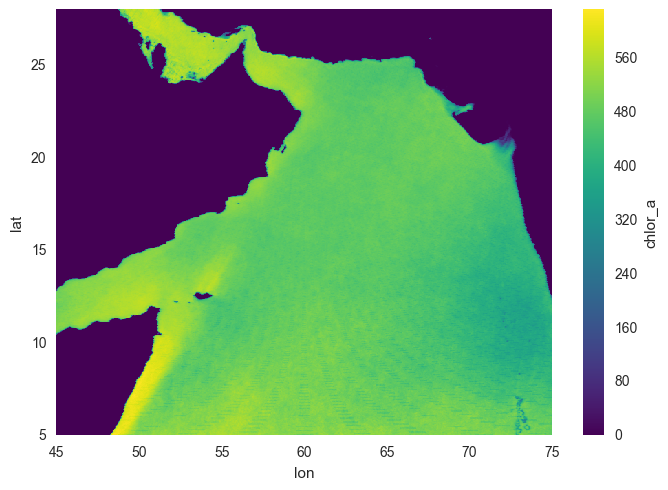

In [10]:
# Count the number of ocean data points
(ds_8day.chlor_a>0).sum(dim='time').plot()

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in greater
  if not reflexive


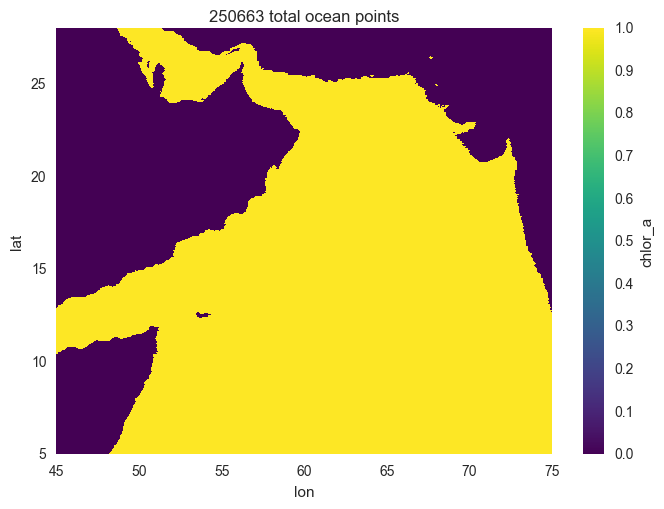

In [11]:
#  find a mask for the land
ocean_mask = (ds_8day.chlor_a>0).sum(dim='time')>0
num_ocean_points = ocean_mask.sum().values
ocean_mask.plot()
plt.title('%g total ocean points' % num_ocean_points)

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


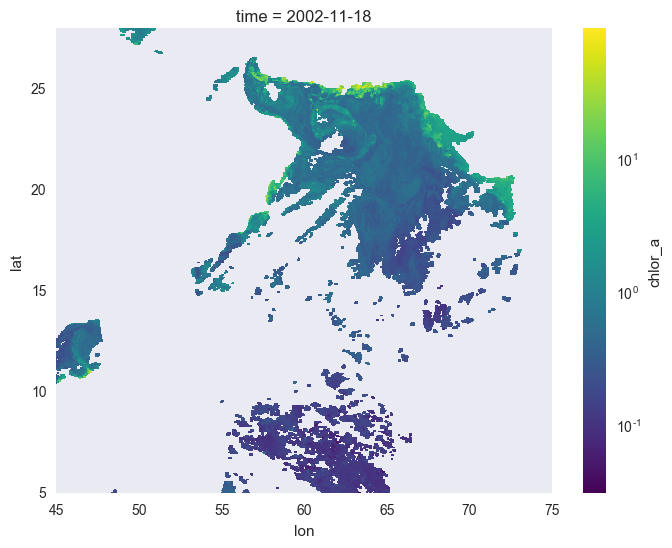

In [12]:
plt.figure(figsize=(8,6))
ds_daily.chlor_a.sel(time='2002-11-18',method='nearest').plot(norm=LogNorm())

In [13]:
ds_daily.groupby('time').count() # information from original data

<xarray.Dataset>
Dimensions:  (time: 5538)
Coordinates:
  * time     (time) datetime64[ns] 2002-04-28 2002-04-29 2002-04-30 ...
Data variables:
    chlor_a  (time) int64 62260 52391 58822 43103 37195 55773 25428 19652 ...

In [14]:
ds_daily.chlor_a.groupby('time').count()/float(num_ocean_points)

<xarray.DataArray 'chlor_a' (time: 5538)>
array([ 0.248381,  0.20901 ,  0.234666, ...,  0.003495,  0.020705,  0.034552])
Coordinates:
  * time     (time) datetime64[ns] 2002-04-28 2002-04-29 2002-04-30 ...

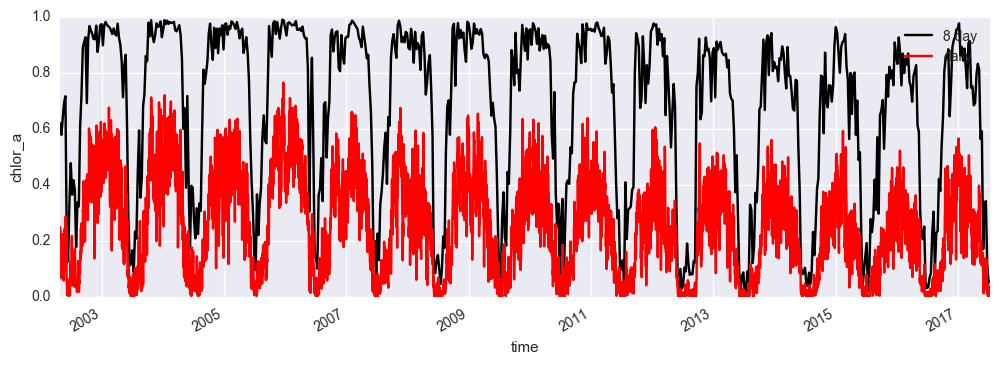

In [15]:
count_8day,count_daily = [ds.chlor_a.groupby('time').count()/float(num_ocean_points)
                            for ds in (ds_8day,ds_daily)]

plt.figure(figsize=(12,4))
count_8day.plot(color='k')
count_daily.plot(color='r')

plt.legend(['8 day','daily'])

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


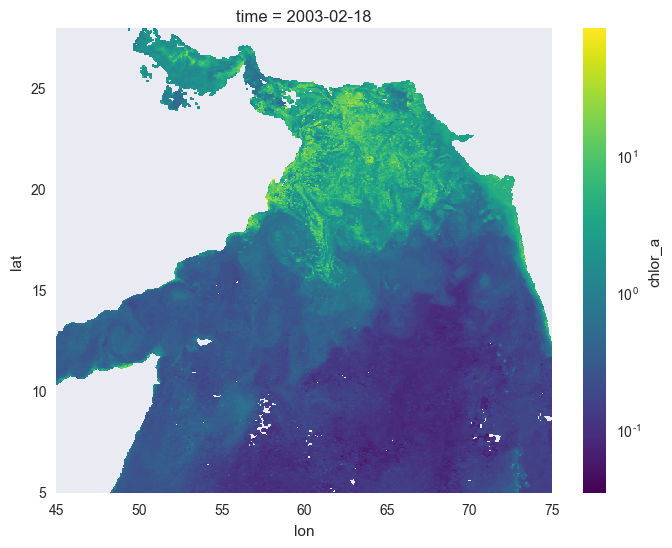

In [16]:
# Maps of individual days
target_date = '2003-02-15'
plt.figure(figsize=(8,6))
ds_8day.chlor_a.sel(time=target_date, method='nearest').plot(norm=LogNorm())

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


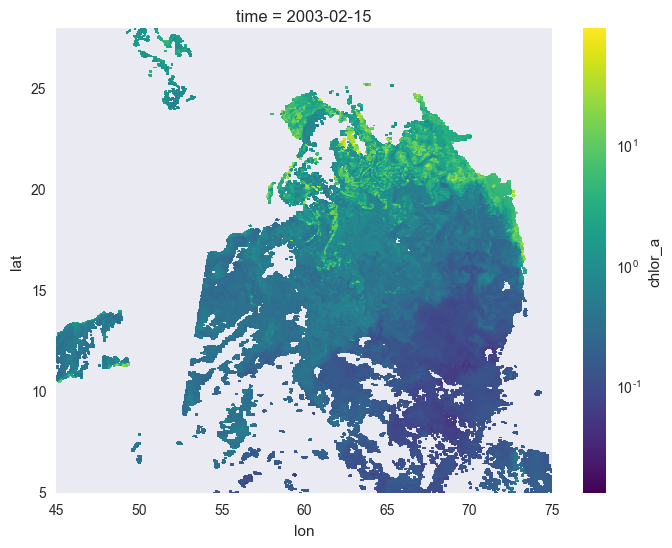

In [17]:
plt.figure(figsize=(8,6))
ds_daily.chlor_a.sel(time=target_date, method='nearest').plot(norm=LogNorm())

In [124]:
freq

15

In [125]:
# next carry out interpolation starts here
freq_resample = str(freq) + 'D'
ds_resample = ds_daily.resample(freq_resample, dim='time')  # see the above for doc, test case, & default behavior
ds_resample

<xarray.Dataset>
Dimensions:  (lat: 553, lon: 721, time: 371)
Coordinates:
  * lat      (lat) float32 28.0208 27.9792 27.9375 27.8958 27.8542 27.8125 ...
  * lon      (lon) float32 44.9792 45.0208 45.0625 45.1042 45.1458 45.1875 ...
  * time     (time) datetime64[ns] 2002-04-28 2002-05-13 2002-05-28 ...
Data variables:
    chlor_a  (time, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


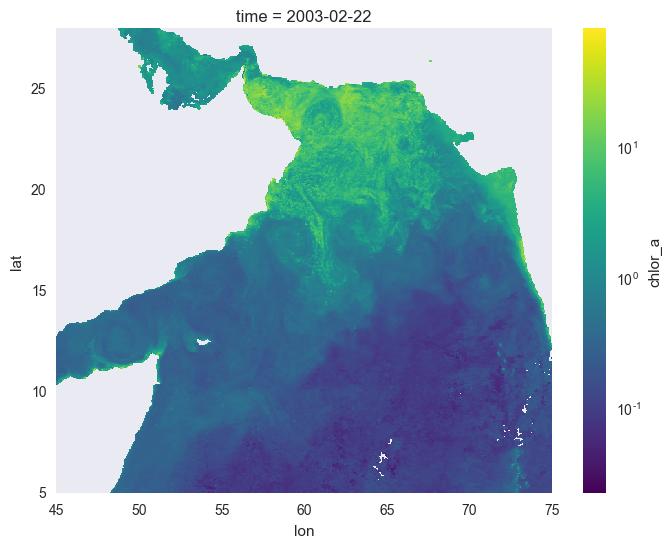

In [126]:
plt.figure(figsize=(8,6))
ds_resample.chlor_a.sel(time=target_date, method='nearest').plot(norm=LogNorm())

In [22]:
# check the range for the longitude
print(ds_resample.lon.min(),'\n' ,ds_resample.lat.min())  

<xarray.DataArray 'lon' ()>
array(44.97917175292969) 
 <xarray.DataArray 'lat' ()>
array(5.020830154418945)


# ++++++++++++++++++++++++++++++++++++++++++++++
# All GDP Floats
# Load the float data
# Map a (time, lon, lat) to a value on the cholorphlly value

In [23]:
from buyodata import buoydata
import os

In [24]:
fnamesAll = ['./gdp_float/buoydata_1_5000.dat','./gdp_float/buoydata_5001_10000.dat','./gdp_float/buoydata_10001_15000.dat','./gdp_float/buoydata_15001_jun16.dat']

In [25]:
# read them and cancatenate them into one DataFrame
dfAll = pd.concat([buoydata.read_buoy_data(f) for f in fnamesAll])  # around 4~5 minutes

#mask = df.time>='2002-07-04' # we only have data after this data for PAR
dfvvAll = dfAll[dfAll.time>='2002-07-04']

sum(dfvvAll.time<'2002-07-04') # recheck whether the time is 

0

In [26]:
# process the data so that the longitude are all >0
print('before processing, the minimum longitude is%f4.3 and maximum is %f4.3' % (dfvvAll.lon.min(), dfvvAll.lon.max()))
mask = dfvvAll.lon<0
dfvvAll.loc[mask].lon = dfvvAll.loc[mask].lon + 360
print('after processing, the minimum longitude is %f4.3 and maximum is %f4.3' % (dfvvAll.lon.min(),dfvvAll.lon.max()) )

dfvvAll.describe()

before processing, the minimum longitude is0.0000004.3 and maximum is 360.0000004.3
after processing, the minimum longitude is 0.0000004.3 and maximum is 360.0000004.3


,id,lat,lon,temp,ve,vn,spd,var_lat,var_lon,var_tmp
count,2.147732e+07,2.131997e+07,2.131997e+07,1.986179e+07,2.129142e+07,2.129142e+07,2.129142e+07,2.147732e+07,2.147732e+07,2.147732e+07
mean,1.765662e+06,-2.263128e+00,2.124412e+02,1.986121e+01,2.454172e-01,4.708192e-01,2.613427e+01,7.326258e+00,7.326555e+00,7.522298e+01
std,9.452835e+06,3.401115e+01,9.746941e+01,8.339498e+00,2.525050e+01,2.052160e+01,1.939087e+01,8.527853e+01,8.527851e+01,2.637454e+02
min,2.578000e+03,-7.764700e+01,0.000000e+00,-1.685000e+01,-2.916220e+02,-2.601400e+02,0.000000e+00,5.268300e-07,-3.941600e-02,1.001300e-03
25%,4.897500e+04,-3.186000e+01,1.490720e+02,1.437300e+01,-1.411400e+01,-1.044700e+01,1.290300e+01,4.366500e-06,7.512600e-06,1.435700e-03
50%,7.141300e+04,-4.920000e+00,2.153940e+02,2.214400e+01,-5.560000e-01,1.970000e-01,2.176700e+01,8.833600e-06,1.495800e-05,1.691700e-03
75%,1.094330e+05,2.756000e+01,3.064370e+02,2.688900e+01,1.356100e+01,1.109300e+01,3.405900e+01,1.833300e-05,3.627900e-05,2.294200e-03
max,6.399288e+07,8.989900e+01,3.600000e+02,4.595000e+01,4.417070e+02,2.783220e+02,4.421750e+02,1.000000e+03,1.000000e+03,1.000000e+03


In [27]:
# Select only the arabian sea region
arabian_sea = (dfvvAll.lon > 45) & (dfvvAll.lon< 75) & (dfvvAll.lat> 5) & (dfvvAll.lat <28)
# arabian_sea = {'lon': slice(45,75), 'lat': slice(5,28)} # later use this longitude and latitude
floatsAll = dfvvAll.loc[arabian_sea]   # directly use mask
print('dfvvAll.shape is %s, floatsAll.shape is %s' % (dfvvAll.shape, floatsAll.shape) )


dfvvAll.shape is (21477317, 11), floatsAll.shape is (111894, 11)


In [28]:
# pands dataframe cannot do the resamplingn properly
# cause we are really indexing on ['time','id'], pandas.dataframe.resample cannot do this
# TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'MultiIndex'


In [127]:
# dump the surface floater data from pandas.dataframe to xarray.dataset
floatsDSAll = xr.Dataset.from_dataframe(floatsAll.set_index(['time','id']) ) # set time & id as the index); use reset_index to revert this operation
floatsDSAll

<xarray.Dataset>
Dimensions:  (id: 259, time: 17499)
Coordinates:
  * time     (time) datetime64[ns] 2002-07-04 2002-07-04T06:00:00 ...
  * id       (id) int64 7574 10206 10208 11089 15703 15707 27069 27139 28842 ...
Data variables:
    lat      (time, id) float64 nan 16.3 14.03 16.4 14.04 nan 20.11 nan ...
    lon      (time, id) float64 nan 66.23 69.48 64.58 69.51 nan 68.55 nan ...
    temp     (time, id) float64 nan nan nan 28.0 28.53 nan 28.93 nan 27.81 ...
    ve       (time, id) float64 nan 8.68 5.978 6.286 4.844 nan 32.9 nan ...
    vn       (time, id) float64 nan -13.18 -18.05 -7.791 -17.47 nan 15.81 ...
    spd      (time, id) float64 nan 15.78 19.02 10.01 18.13 nan 36.51 nan ...
    var_lat  (time, id) float64 nan 0.0002661 5.01e-05 5.018e-05 5.024e-05 ...
    var_lon  (time, id) float64 nan 0.0006854 8.851e-05 9.018e-05 8.968e-05 ...
    var_tmp  (time, id) float64 nan 1e+03 1e+03 0.003733 0.0667 nan 0.001683 ...

In [128]:
print(floatsDSAll.dims)
# resample on the xarray.dataset onto two-day frequency
floatsDSAll_resample =floatsDSAll.resample(freq_resample, dim='time')
print(floatsDSAll_resample.dims)   # downsampling on the 'time' dimension 17499/9/4=  around 486
floatsDSAll_resample

Frozen(SortedKeysDict({'time': 17499, 'id': 259}))
Frozen(SortedKeysDict(OrderedDict([('time', 341), ('id', 259)])))


<xarray.Dataset>
Dimensions:  (id: 259, time: 341)
Coordinates:
  * time     (time) datetime64[ns] 2002-07-04 2002-07-19 2002-08-03 ...
  * id       (id) int64 7574 10206 10208 11089 15703 15707 27069 27139 28842 ...
Data variables:
    lat      (time, id) float64 nan 16.27 13.55 15.66 13.61 nan 19.97 nan ...
    lon      (time, id) float64 nan 66.66 70.2 65.25 70.17 nan 70.05 nan ...
    temp     (time, id) float64 nan nan nan 27.77 28.59 nan 28.92 nan 27.23 ...
    ve       (time, id) float64 nan 6.14 11.37 9.377 10.19 nan 25.86 nan ...
    vn       (time, id) float64 nan 0.3577 -5.286 -14.1 -4.513 nan -5.424 ...
    spd      (time, id) float64 nan 7.395 15.01 18.7 13.97 nan 27.87 nan ...
    var_lat  (time, id) float64 nan 0.001451 6.257e-05 6.695e-05 5.535e-05 ...
    var_lon  (time, id) float64 nan 0.00561 0.0001185 0.0001289 0.000102 nan ...
    var_tmp  (time, id) float64 nan 1e+03 1e+03 0.003614 0.08862 nan ...

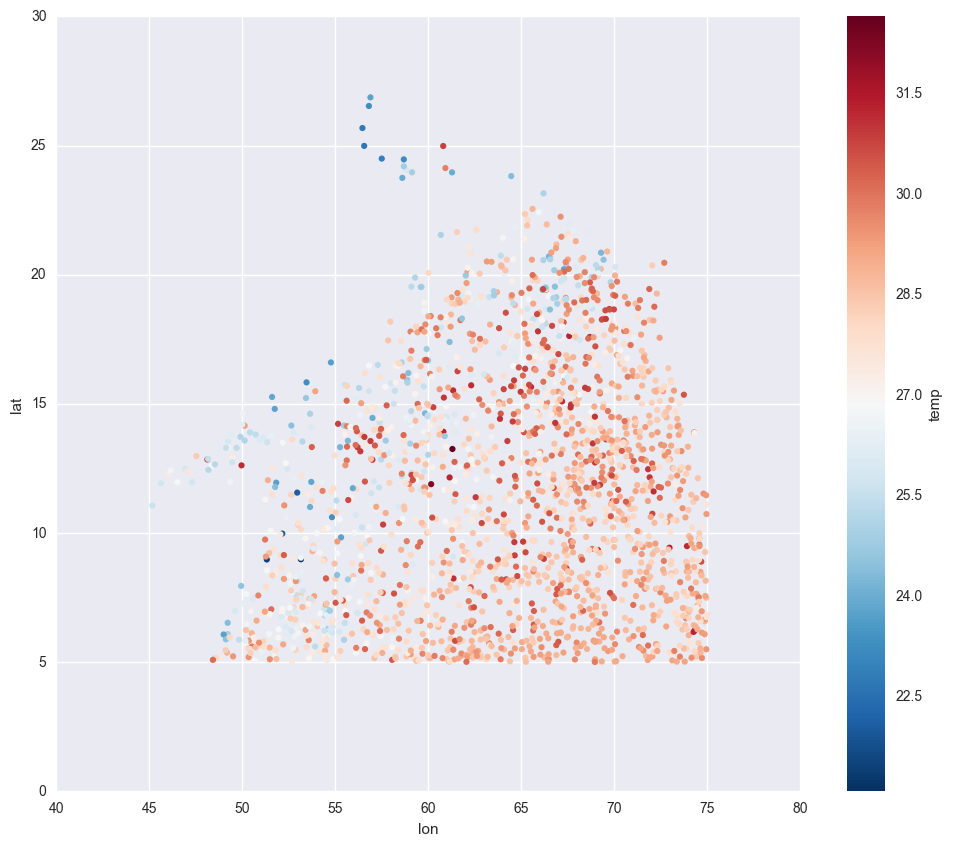

In [129]:
# transfer it back to pandas.dataframe for plotting
floatsDFAll_resample = floatsDSAll_resample.to_dataframe()
floatsDFAll_resample
floatsDFAll_resample = floatsDFAll_resample.reset_index()
floatsDFAll_resample
# visualize the subsamping of floats around arabian region
fig, ax  = plt.subplots(figsize=(12,10))
floatsDFAll_resample.plot(kind='scatter', x='lon', y='lat', c='temp', cmap='RdBu_r', edgecolor='none', ax=ax)

In [130]:
# get the value for the chlorophyll for each data entry
floatsDFAll_resample_timeorder = floatsDFAll_resample.sort_values(['time','id'],ascending=True)
floatsDFAll_resample_timeorder[:20] # check whether it is time ordered!!
# should we drop nan to speed up??

,id,time,lat,lon,temp,ve,vn,spd,var_lat,var_lon,var_tmp
0,7574,2002-07-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
341,10206,2002-07-04,16.265717,66.663800,NaN,6.140233,0.357733,7.394967,0.001451,0.005610,1000.000000
682,10208,2002-07-04,13.549633,70.195217,NaN,11.373300,-5.285617,15.006967,0.000063,0.000118,1000.000000
1023,11089,2002-07-04,15.657150,65.248067,27.773283,9.376883,-14.097033,18.695917,0.000067,0.000129,0.003614
1364,15703,2002-07-04,13.611350,70.165200,28.590333,10.194983,-4.513033,13.965250,0.000055,0.000102,0.088623
1705,15707,2002-07-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2046,27069,2002-07-04,19.969700,70.048350,28.916267,25.855350,-5.424417,27.865400,0.000057,0.000106,0.001731
2387,27139,2002-07-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2728,28842,2002-07-04,18.350883,60.961600,27.226833,5.825783,-9.921900,16.832533,0.000149,0.000362,0.003382
3069,34159,2002-07-04,13.394633,60.516650,NaN,31.603317,16.559017,36.755683,0.000061,0.000116,1000.000000


(88319,)
(2195,)
          id       time  lat  lon  temp  ve  vn  spd  var_lat  var_lon  \
34100  62558 2002-07-04  NaN  NaN   NaN NaN NaN  NaN      NaN      NaN   
34441  63036 2002-07-04  NaN  NaN   NaN NaN NaN  NaN      NaN      NaN   
34782  63067 2002-07-04  NaN  NaN   NaN NaN NaN  NaN      NaN      NaN   
35123  63068 2002-07-04  NaN  NaN   NaN NaN NaN  NaN      NaN      NaN   
35464  63069 2002-07-04  NaN  NaN   NaN NaN NaN  NaN      NaN      NaN   

       var_tmp  
34100      NaN  
34441      NaN  
34782      NaN  
35123      NaN  
35464      NaN  
          id       time        lat        lon       temp         ve  \
35589  63069 2007-08-22  15.798379  58.013000  25.771362  45.319667   
35590  63069 2007-09-06  17.658433  59.207817  26.384367   3.862417   
35591  63069 2007-09-21  16.433267  61.175617  27.712067   7.830650   
35592  63069 2007-10-06  16.330617  60.592183  28.309833  -4.990567   
35593  63069 2007-10-21  19.042383  61.008650  28.125817   5.503000   
35594  630

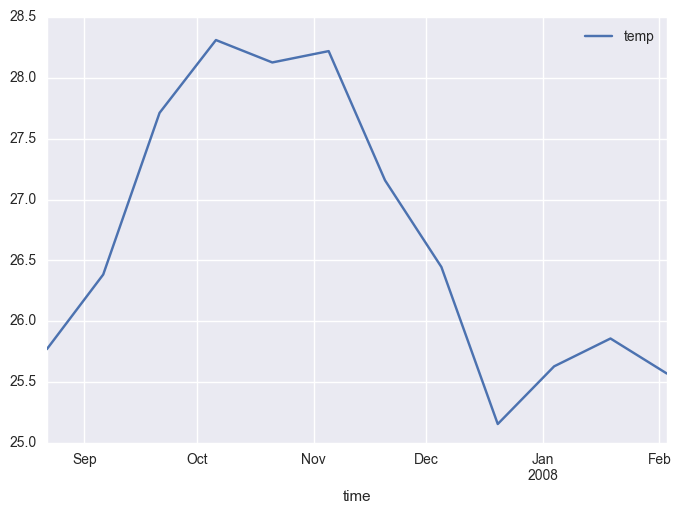

In [131]:
print(floatsDFAll_resample_timeorder.lon.shape)
print(floatsDFAll_resample_timeorder.lon.dropna().shape )

############ interpolation starts from here
# to understand the float data better
# a: Look into the floatsDFAll_9Dtimeorder data in more details
# check the nan counts in each id
# plot the trajectory of {time, lat, lon, temperature,} for each float id,  
# this steps helps to understand the float dataset and if there is a need, improve it.

# b: take the float data as it is, and do the interpolation, whenever there is a nan value use the nearest neigbhours....
# check whether the quality of interpolataion is improved, if not, then have to fall back to to task 1

# c: vectorization

# DataFrame panel data 
# floatsDFAll_9Dtimeorder.set_index(['id','time']) 
# the inverse operation # floatsDFAll_9Dtimeorder.reset_index()
# look into the data
print(floatsDFAll_resample_timeorder[100:105])
# so far there is no need to convert it into a panel 
# floatsDFAll_9DtimeorderPanel = floatsDFAll_9Dtimeorder.to_panel

# plot the temperature for one float, the temperature do have a trend
#maskid = (floatsDFAll_resample_timeorder.id == 63069) & (floatsDFAll_resample_timeorder.time > '2007-01-01') & (floatsDFAll_resample_timeorder.time < '2009-01-01')
maskid = (floatsDFAll_resample_timeorder.id == 63069)
print(floatsDFAll_resample_timeorder[maskid].dropna(subset=['id', 'lat', 'lon', 'time']) )
floatsDFAll_resample_timeorder[maskid].dropna(subset=['id', 'lat', 'lon', 'time']).plot(x='time', y ='temp')

# set of all float ids
print(floatsDFAll_resample_timeorder.id.unique())

# this is a float that explains the need for temperature data
maskid2 = floatsDFAll_resample_timeorder.id == 10208
print(floatsDFAll_resample_timeorder[maskid2].head())


In [132]:
################
# test case 1: take a single entry (southeast corner for valid values)
row_case1 =  pd.DataFrame(data = {'time':'2002-07-13 00:00:00', 'id': 10206, 'lon':74.7083358765, 'lat':5.20833349228},index=[1])
print(row_case1)

################
# test case 2
# take a {time-list, id-list, lon-list, lat-list}, index-list 
# carry out the interpolation
#row_case2 =  pd.DataFrame(data = {'time':['2002-07-13 00:00:00','2002-07-22 00:00:00'] , 'id': [10206, 10206], 'lon':[74.7083358765, 74.6250076294], 'lat':[5.20833349228, 5.29166173935]},index=[2,3])
#print(row_case2)
################
# test case 3
row_case2 =  pd.DataFrame(data = {'time':['2002-07-13 00:00:00', '2002-07-22 00:00:00', '2002-07-13 00:00:00'] , 'id': [10206, 10206, 10206], 'lon':[74.7083358765, 74.6250076294,74.7083358765], 'lat':[5.20833349228, 5.29166173935, 5.20833349228]},index=[1,2,3])
print(row_case2)



####
## get the indices of time, lat, lon
idx_time = ds_resample.indexes['time']
idx_lat = ds_resample.indexes['lat']
idx_lon = ds_resample.indexes['lon']

#### 
#interpolation on the time dimension
time_len = len(row_case2.time.values)
xtime_test = list([ np.datetime64(row_case2.time.values[i]) for i in range(0,time_len)  ] )  # for delta 
print('\n xtime_test \n', xtime_test)

'''caution: cannot do this inside the function get_loc,
see https://github.com/pandas-dev/pandas/issues/3488
'''
itime_nearest = [idx_time.get_loc(xtime_test[i], method='nearest') for i in range(0, time_len)]
print('\n itime_nearest \n', itime_nearest)  # [1,2]

xtime_nearest =  ds_resample.time[itime_nearest].values  #  ['2002-07-13T00:00:00.000000000' '2002-07-22T00:00:00.000000000']
print('\n xtime_nearest\n', xtime_nearest)  # ['2002-07-13T00:00:00.000000000' '2002-07-22T00:00:00.000000000']
print('xtime_nearest', type(xtime_nearest)) # xtime_nearest <class 'numpy.ndarray'> # time_nearest <class 'numpy.datetime64'>

# the time distance in days
delta_xtime = (xtime_test - xtime_nearest) / np.timedelta64(1, 'D')
print('\n delta_xtime in days \n', delta_xtime)
print(type(delta_xtime))

itime_next = [itime_nearest[i]+1 if  delta_xtime[i] >=0  else itime_nearest[i]-1  for i in range(0, time_len) ]
print('\n itime_next \n',itime_next)  # [2, 3]

# find the next coordinate values
xtime_next = ds_resample.time[itime_next].values
print('\n xtime_next \n', xtime_next) # ['2002-07-22T00:00:00.000000000' '2002-07-31T00:00:00.000000000']

# prepare for the Tri-linear interpolation
base_time = (xtime_next - xtime_nearest) / np.timedelta64(1, 'D')  # [ 9.  9.]
print('\n base_time \n', base_time)
w_time = delta_xtime / base_time  
print('\n w_time \n', w_time) # [ 0.  0.]


#### 
#interpolation on the lat dimension
xlat_test = row_case2.lat.values + 0.06   # base [ 5.20833349  5.29166174] # cell distance around .8, use .2 & .6 as two tests
print('\n xlat_test \n', xlat_test)       # xlat_test [ 5.26833349  5.35166174]

ilat_nearest = [idx_lat.get_loc(xlat_test[i], method='nearest') for i in range(0, time_len)]
print('\n ilat_nearest \n', ilat_nearest) # [272, 271]

xlat_nearest = ds_resample.lat[ilat_nearest].values  
print('\n xlat_nearest \n', xlat_nearest) # [ 5.29166174  5.37499762]

delta_xlat = xlat_test - xlat_nearest
print("\n delta_xlat \n",delta_xlat)      #  [-0.02332825 -0.02333588]


# the nearest index is on the right; but order of the latitude is different, it is descending
ilat_next = [ilat_nearest[i]-1 if  delta_xlat[i] >=0  else ilat_nearest[i]+1  for i in range(0, time_len) ]
print('\n ilat_next \n', ilat_next)  # [273, 272]

# find the next coordinates value
xlat_next = ds_resample.lat[ilat_next].values
print('\n xlat_next \n', xlat_next)  # [ 5.20833349  5.29166174]

# prepare for the Tri-linear interpolation
w_lat = delta_xlat / (xlat_next - xlat_nearest)
print('\n w_lat \n', w_lat) # [ 0.27995605  0.28002197]

#### 
#interpolation on the lon dimension
xlon_test = row_case2.lon.values +0.06 # base [74.7083358765, 74.6250076294] # cell distance around .8, use .2 & .6 as two tests
print('\n xlon_test \n', xlon_test)  # [ 74.76833588  74.68500763]

ilon_nearest = [idx_lon.get_loc(xlon_test[i], method='nearest') for i in range(0, time_len)]
print('\n ilon_nearest \n', ilon_nearest) # [357, 356]

xlon_nearest = ds_resample.lon[ilon_nearest].values  
print('\n xlon_nearest \n', xlon_nearest) # [ 74.79166412  74.70833588]

delta_xlon = xlon_test - xlon_nearest     
print("\n delta_xlon \n", delta_xlon)     #  [-0.02332825 -0.02332825]

ilon_next = [ilon_nearest[i]+1 if  delta_xlon[i] >=0  else ilon_nearest[i]-1  for i in range(0, time_len) ]
print('\n ilon_next \n',ilon_next)  # [356, 355]

# find the next coordinate values
xlon_next = ds_resample.lon[ilon_next].values
print("\n xlon_next \n", xlon_next) # [ 74.70833588  74.62500763]

# prepare for the Tri-linear interpolation
w_lon = delta_xlon / (xlon_next - xlon_nearest)
print("\n w_lon \n", w_lon) # [ 0.27995605  0.27995605]

####
# local Tensor product for Trilinear interpolation
# caution: nan values, store as "list_of_array to 2d_array" first, then sum

# no casting to list needed here, inputs are already lists
tmp = np.array([
         ds_resample.chlor_a.isel_points(time=itime_nearest, lat=ilat_nearest, lon=ilon_nearest).values,
         ds_resample.chlor_a.isel_points(time=itime_nearest, lat=ilat_nearest, lon=ilon_next).values,
         ds_resample.chlor_a.isel_points(time=itime_nearest, lat=ilat_next, lon=ilon_nearest).values,
         ds_resample.chlor_a.isel_points(time=itime_nearest, lat=ilat_next, lon=ilon_next).values,
         ds_resample.chlor_a.isel_points(time=itime_next, lat=ilat_nearest, lon=ilon_nearest).values,
         ds_resample.chlor_a.isel_points(time=itime_next, lat=ilat_nearest, lon=ilon_next).values,
         ds_resample.chlor_a.isel_points(time=itime_next, lat=ilat_next, lon=ilon_nearest).values,
         ds_resample.chlor_a.isel_points(time=itime_next, lat=ilat_next, lon=ilon_next).values ])

weights =  np.array([(1-w_time)*(1-w_lat)*(1-w_lon), 
                     (1-w_time)*(1-w_lat)*w_lon,
                     (1-w_time)*w_lat*(1-w_lon), 
                     (1-w_time)*w_lat*w_lon,
                        w_time*(1-w_lat)*(1-w_lon),
                        w_time*(1-w_lat)*w_lon,
                        w_time*w_lat*(1-w_lon),
                        w_time*w_lat*w_lon ])


# how to deal with "nan" values, fill in missing values for the np.array tmpAll 
# or fill the mean values to the unweighted array
# http://stackoverflow.com/questions/18689235/numpy-array-replace-nan-values-with-average-of-columns

print('\n neighbouring tensor used \n', tmp)
'''
 neighbouring tensor used 
 [[        nan  0.181841  ]
 [ 0.245878           nan]
 [        nan         nan]
 [        nan         nan]
 [ 0.19680101         nan]
 [        nan         nan]
 [        nan         nan]
 [ 0.18532801         nan]]
'''

# column min: (nan+0.245878 + nan + nan + 0.19680101 + nan +  nan + 0.18532801)/8 = 0.20933567333
col_mean = np.nanmean(tmp, axis=0)
print('\n its mean along axis 0(column) \n', col_mean)  #  [ 0.20933567  0.181841  ]


# filling the missing values.
inds = np.where(np.isnan(tmp))
print('\n nan index\n', inds)
tmp[inds]=np.take(col_mean, inds[1])
print('\n values after the fill \n', tmp)

print('\n weighting tensor used \n', weights)

print("weights.shape", weights.shape) # (8, 3)
print("tmp.shape", tmp.shape)  # (8, 3)

nrow_w, ncol_w = weights.shape
nrow_t, ncol_t = tmp.shape
assert nrow_w == nrow_t, "the row count of weights and values are not the same!"
assert ncol_w == ncol_t, "the row count of weights and values are not the same!"
print('\n tensor product\n', np.dot(weights[:,0], tmp[:,0]) ) # 0.216701896135 should be [ 0.2167019]

# new interpolation process of the Chl_a
chl_new = np.empty(ncol_w)
for i in range(0, ncol_w, 1):
    chl_new[i] =  np.dot(weights[:,i], tmp[:,i])

print('chl_newInt',  chl_new) #  [ 0.2167019  0.181841   0.2167019]
# validate by 1D array
# val = np.array([0.20933567, 0.245878,  0.20933567,
#                0.20933567, 0.19680101, 0.20933567,
#               0.20933567,0.18532801]) 
# np.dot(val, weights) # 0.21670189702309739


## output xarray.dataarray of points, see examples below
# this is the way how xarray.Dataset works
# if you want a xarray.DataArray, first generate a xarray.Dataset, then select DataArray from there.
chl_newInt = xr.Dataset({'chl': (['points'], np.random.randn(3))},
                        coords={
                                'time':(['points'],['2002-07-13 00:00:00', '2002-07-22 00:00:00', '2002-07-13 00:00:00']) , 
                                'id': (['points'], [10206, 10206, 10206]), 
                                'lon': (['points'], [74.7083358765, 74.6250076294,74.7083358765]),
                                'lat':(['points'], [5.20833349228, 5.29166173935, 5.20833349228]), 
                                'points': (['points'], [0,1,2])}) # this way the dims is set to point

print('\n',chl_newInt.chl)
'''
### Task: output xarray.dataarray as points
## example 1
arr = xr.DataArray(np.random.rand(4,3), [('time', pd.date_range('2000-01-01', periods=4)), ('space', ['IA', 'IL', 'IN'])] )
print("first example",arr)
print("\n \n")

## example2 -- concrete xr.DataArray
data = np.random.rand(4, 3)
locs = ['IA', 'IL', 'IN']
times = pd.date_range('2000-01-01', periods=4)
brr = xr.DataArray(data, coords={'time': times, 'space': locs, 'const': 42, \
                          'ranking': ('space', [1, 2, 3])}, \
             dims=['time', 'space'])
print("second example",brr)
'''

'''
### the target output
#the output generated by the xarray.DataSet => xarray.DataArray
<xarray.DataArray 'chlor_a' (points: 147112)>
array([ nan,  nan,  nan, ...,  nan,  nan,  nan])
Coordinates:
    time     (points) datetime64[ns] 2002-07-04 2002-07-04 2002-07-04 ...
    lon      (points) float64 74.96 66.54 69.88 65.04 69.88 74.96 69.46 ...
    lat      (points) float64 27.96 16.21 13.62 16.04 13.62 27.96 20.04 ...
  * points   (points) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  
### the solution approach we tried to is: first,  generate a xarray.DataSet
                                          second, generte a xarray.DataArray from the xarray DataSet if needed.
 
# 1. looking at this example, DataArray seems to be working.

# works here
da_test1 = xr.DataArray(np.random.rand(3), dims=['x'],
                        coords={'x': np.array([10206, 10206, 10206]), 'y':  2} )
print('\n da_test1', da_test1)

##########
# but not works here
da_test1 = xr.DataArray(np.random.rand(3), dims=['x'],
                        coords={'x': np.array([10206, 10206, 10206]), 'y':  np.array([10206, 10206, 10206])} )
print('\n da_test1', da_test1)

# err's
##########

##########
# works here
da_test1 = xr.DataArray(np.random.rand(3), dims=['x'],
                        coords={'x': np.array([10206, 10206, 10206]), 'y':  2} )
print('\n da_test1', da_test1)

# da_test1 <xarray.DataArray (x: 3)>
# array([ 0.90386212,  0.21516239,  0.44707272])
# Coordinates:
#   * x        (x) int64 10206 10206 10206
#     y        int64 2
##########

##########
# so we do this
# this is the way how xarray.Dataset works
# if you want a xarray.DataArray, first generate a xarray.Dataset, then select DataArray from there.
chl_newInt = xr.Dataset({'chl': (['id'], np.random.randn(3))},
                        coords={ 
                           'id':  (['id'], np.array([10206, 10206, 10206])), 
                           'lon': (['id'], np.array([74.7083358765, 74.6250076294,74.7083358765])), 
                           'lat': (['id'], np.array([5.20833349228, 5.29166173935, 5.20833349228]))})
print('chl_newInt', chl_newInt) # generate the xarray.DataSet
print('\n \n')
print('chl_newInt.chl', chl_newInt.chl) # xarray.DataSet contains many xarray.DataArray


#chl_newInt <xarray.Dataset>
#Dimensions:  (id: 3)
#Coordinates:
#    lon      (id) float64 74.71 74.63 74.71
#  * id       (id) int64 10206 10206 10206
#    lat      (id) float64 5.208 5.292 5.208
#Data variables:
#    chl      (id) float64 0.783 -0.9714 -0.3206



#chl_newInt.chl <xarray.DataArray 'chl' (id: 3)>
#array([ 0.78301614, -0.97144208, -0.3206447 ])
#Coordinates:
#    lon      (id) float64 74.71 74.63 74.71
#  * id       (id) int64 10206 10206 10206
#    lat      (id) float64 5.208 5.292 5.208

'''
print()

      id       lat        lon                 time
1  10206  5.208333  74.708336  2002-07-13 00:00:00
      id       lat        lon                 time
1  10206  5.208333  74.708336  2002-07-13 00:00:00
2  10206  5.291662  74.625008  2002-07-22 00:00:00
3  10206  5.208333  74.708336  2002-07-13 00:00:00

 xtime_test 
 [numpy.datetime64('2002-07-13T00:00:00'), numpy.datetime64('2002-07-22T00:00:00'), numpy.datetime64('2002-07-13T00:00:00')]

 itime_nearest 
 [5, 6, 5]

 xtime_nearest
 ['2002-07-12T00:00:00.000000000' '2002-07-27T00:00:00.000000000'
 '2002-07-12T00:00:00.000000000']
xtime_nearest <class 'numpy.ndarray'>

 delta_xtime in days 
 [ 1. -5.  1.]
<class 'numpy.ndarray'>

 itime_next 
 [6, 5, 6]

 xtime_next 
 ['2002-07-27T00:00:00.000000000' '2002-07-12T00:00:00.000000000'
 '2002-07-27T00:00:00.000000000']

 base_time 
 [ 15. -15.  15.]

 w_time 
 [ 0.06666667  0.33333333  0.06666667]

 xlat_test 
 [ 5.26833349  5.35166174  5.26833349]

 ilat_nearest 
 [546, 544, 546]

 xlat_

In [133]:
### output benchmark
### output the dataset ds_9day and output the dataframe  
#ds_9day.to_netcdf("ds_9day.nc")

#row_case4 = pd.DataFrame(data={'time':list(floatsDFAll_9Dtimeorder.time), 'lon':list(floatsDFAll_9Dtimeorder.lon), 'lat':list(floatsDFAll_9Dtimeorder.lat), 'id':list(floatsDFAll_9Dtimeorder.id) } )
##print('\n before dropping nan \n', row_case4)
## process to drop nan in any of the columns [id], [lat], [lon], [time]
#row_case4 = row_case4.dropna(subset=['id', 'lat', 'lon', 'time'], how = 'any') # these four fields are critical
#row_case4.to_csv("row_case4.csv")

In [134]:
floatsDFAll_resample_timeorder

,id,time,lat,lon,temp,ve,vn,spd,var_lat,var_lon,var_tmp
0,7574,2002-07-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
341,10206,2002-07-04,16.265717,66.663800,NaN,6.140233,0.357733,7.394967,0.001451,0.005610,1000.000000
682,10208,2002-07-04,13.549633,70.195217,NaN,11.373300,-5.285617,15.006967,0.000063,0.000118,1000.000000
1023,11089,2002-07-04,15.657150,65.248067,27.773283,9.376883,-14.097033,18.695917,0.000067,0.000129,0.003614
1364,15703,2002-07-04,13.611350,70.165200,28.590333,10.194983,-4.513033,13.965250,0.000055,0.000102,0.088623
1705,15707,2002-07-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2046,27069,2002-07-04,19.969700,70.048350,28.916267,25.855350,-5.424417,27.865400,0.000057,0.000106,0.001731
2387,27139,2002-07-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2728,28842,2002-07-04,18.350883,60.961600,27.226833,5.825783,-9.921900,16.832533,0.000149,0.000362,0.003382
3069,34159,2002-07-04,13.394633,60.516650,NaN,31.603317,16.559017,36.755683,0.000061,0.000116,1000.000000


In [135]:
#### Interface modification
# Generalized interface
# -- using dataframe to generalize the interpolation operation
# -- dataset for resampling and difference along dim='time', 
#   with coord = {'time','id'}


#### the approach using Linear Interpolations with 3D tensors
# Keyword Arguments
# approach 1 
# each of the indexers component might be ordered differently
#############
# def sel_points_multilinear(dset, dims='points', out = 'str', **indexers):
## test case
# def sel_points_multilinear(ds_9day, dims = 'points', out ='chlor_a', 
#                            time = list(['2002-07-13 00:00:00']),
#                            lat = list([5]),  lon = list([70]) ):
############
# e.g. time-ascending, lat-descending, need to tell 'time' from 'lat'
# use different parameters for inputs
## approach 2 
## from dataframe to dataset
## input:
##     dframe: list of {time}, {lan}, {lon}, {id}. bounds-aware
##     dset:   carry out the interpolation use dset data structure and its component 
## output:
##     a list or dataframe with chl_newInt.chl

# remember to take log_e instead of log_10

# clean up this notebook, seperate, clean, and take notes

# test case 4: use the full real data
#del(interpolate)
#del(sel_points_multilinear)
# froms dir import src  # to call src.functions
from tools.time_lat_lon_interpolate import interpolate
importlib.reload(interpolate)

# process to drop nan in any of the columns [id], [lat], [lon], [time]
row_case4 = floatsDFAll_resample_timeorder.dropna(subset=['id', 'lat', 'lon', 'time'], how = 'any') # these four fields are critical
# print('\n after dropping nan \n', row_case4)
result_out4 = interpolate.sel_points_multilinear_time_lat_lon(ds_resample, row_case4, dims = 'points', col_name ='chlor_a')
print('\n *** after the interpolation *** \n', result_out4)
# important: keep the id, since the dataframe has been modified in a bound-aware way in the function
print('\n *** this two length should be equal *** %d >= %d?' %(len(row_case4.index), len(result_out4.index) ) )  


/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/pandas/core/indexing.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)



 *** after the interpolation *** 
              id       time        lat        lon       temp         ve  \
341       10206 2002-07-04  16.265717  66.663800        NaN   6.140233   
682       10208 2002-07-04  13.549633  70.195217        NaN  11.373300   
1023      11089 2002-07-04  15.657150  65.248067  27.773283   9.376883   
1364      15703 2002-07-04  13.611350  70.165200  28.590333  10.194983   
2046      27069 2002-07-04  19.969700  70.048350  28.916267  25.855350   
2728      28842 2002-07-04  18.350883  60.961600  27.226833   5.825783   
3069      34159 2002-07-04  13.394633  60.516650        NaN  31.603317   
3751      34210 2002-07-04   5.882953  56.749953  26.354721  -5.144814   
4092      34211 2002-07-04   7.797533  69.070367  28.430017  19.858683   
4433      34212 2002-07-04   6.519433  66.877317  28.568833  34.703000   
5115      34310 2002-07-04   5.023286  70.029000  28.954857   8.074714   
5456      34311 2002-07-04   9.730864  69.980455  28.593818  -2.896714   
57

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/pandas/core/indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


             id        time        lat        lon       temp         ve  \
341       10206  2002-07-04  16.265717  66.663800        NaN   6.140233   
682       10208  2002-07-04  13.549633  70.195217        NaN  11.373300   
1023      11089  2002-07-04  15.657150  65.248067  27.773283   9.376883   
1364      15703  2002-07-04  13.611350  70.165200  28.590333  10.194983   
2046      27069  2002-07-04  19.969700  70.048350  28.916267  25.855350   
2728      28842  2002-07-04  18.350883  60.961600  27.226833   5.825783   
3069      34159  2002-07-04  13.394633  60.516650        NaN  31.603317   
3751      34210  2002-07-04   5.882953  56.749953  26.354721  -5.144814   
4092      34211  2002-07-04   7.797533  69.070367  28.430017  19.858683   
4433      34212  2002-07-04   6.519433  66.877317  28.568833  34.703000   
5115      34310  2002-07-04   5.023286  70.029000  28.954857   8.074714   
5456      34311  2002-07-04   9.730864  69.980455  28.593818  -2.896714   
5797      34312  2002-07-

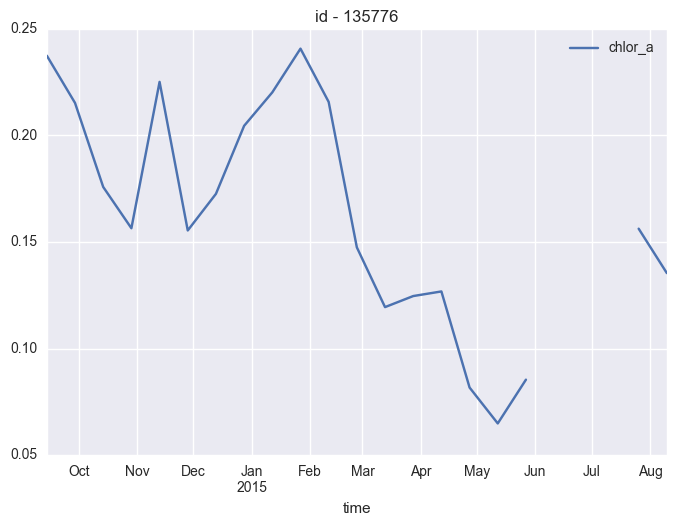

In [136]:
# output the dataframe result_out4
var1 = "chl"
outdir_prefix = "./data_globcolour/output.data/interpolate/" + "df_Globcolor_"
outdir = outdir_prefix + var1 + "_" + str(freq) + "d.csv"
result_out4.to_csv(outdir)
print(pd.read_csv(outdir,index_col=0))

### plot for id 125776, which will be fit by LDS
plt.figure(figsize=(8,6))
result_out4[result_out4.id == 135776].plot(x='time', y ='chlor_a', title=('id - %d' % 135776) )
plt.show();
plt.close("all")

after processing, the minimum longitude is 0.0200004.3 and maximum is 359.9800004.3
dist_db.shape is (40500000, 3), dist_db_arabian.shape is (431250, 3)


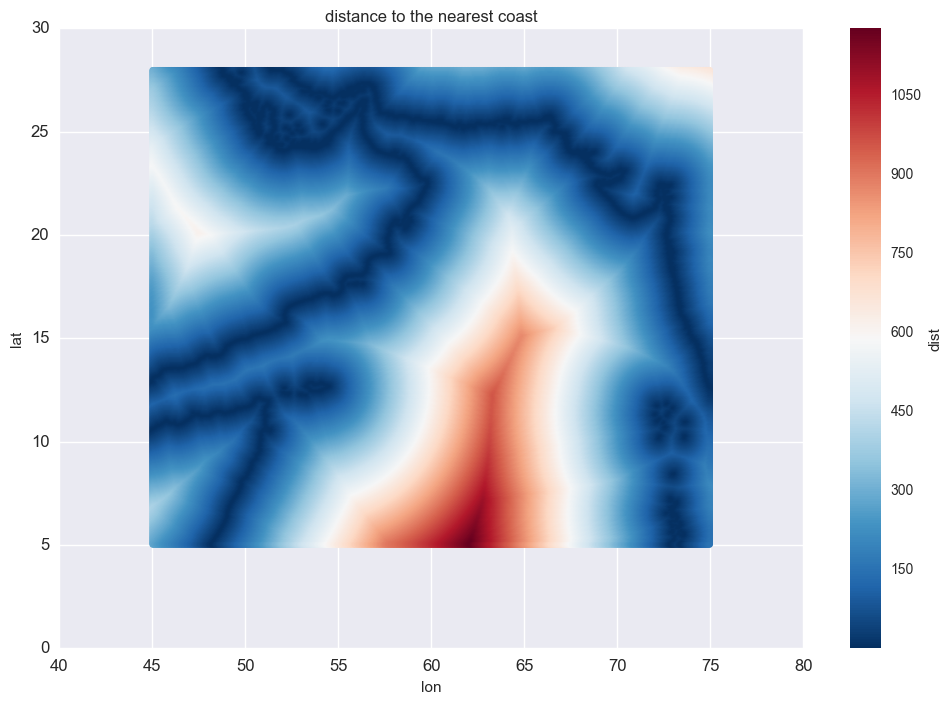


 ******** Interpolation of distance using (lat, lon) ******* 


 *** after the interpolation *** 
              id       time        lat        lon       temp         ve  \
341       10206 2002-07-04  16.265717  66.663800        NaN   6.140233   
682       10208 2002-07-04  13.549633  70.195217        NaN  11.373300   
1023      11089 2002-07-04  15.657150  65.248067  27.773283   9.376883   
1364      15703 2002-07-04  13.611350  70.165200  28.590333  10.194983   
2046      27069 2002-07-04  19.969700  70.048350  28.916267  25.855350   
2728      28842 2002-07-04  18.350883  60.961600  27.226833   5.825783   
3069      34159 2002-07-04  13.394633  60.516650        NaN  31.603317   
3751      34210 2002-07-04   5.882953  56.749953  26.354721  -5.144814   
4092      34211 2002-07-04   7.797533  69.070367  28.430017  19.858683   
4433      34212 2002-07-04   6.519433  66.877317  28.568833  34.703000   
5115      34310 2002-07-04   5.023286  70.029000  28.954857   8.074714   
5456      34

In [137]:
#### now interpolate the distance to the coast
from tools.time_lat_lon_interpolate import interpolate
importlib.reload(interpolate)
from tools import distance
importlib.reload(distance)


result_dist = interpolate.sel_points_multilinear_dist_lat_lon(result_out4, dims='points', col_name='dist') # interpolation

print('\n *** after the interpolation *** \n', result_dist)
# important: keep the id, since the dataframe has been modified in a bound-aware way in the function
print('\n *** this two length should be equal *** %d >= %d?' %(len(result_out4.index), len(result_dist.index) ) )  





 ******* Visualization on 'distance to coast' ******* 



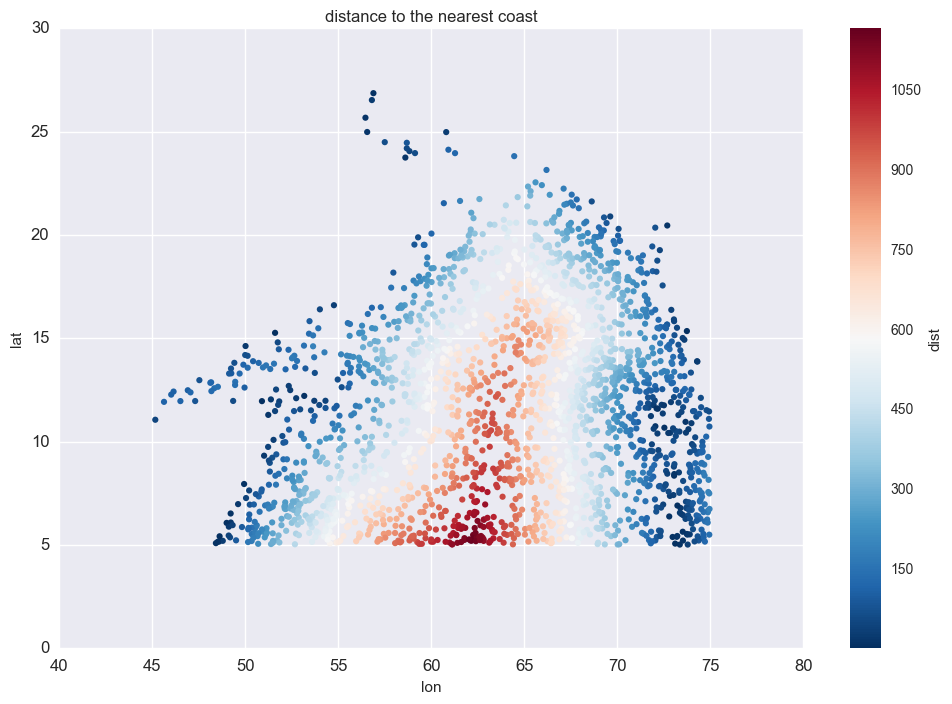

0

In [138]:
from tools import distance
importlib.reload(distance)

print("\n ******* Visualization on 'distance to coast' ******* \n" )
distance.spatial_plots_distance(result_dist)

In [139]:
# output the dataframe result_dist
vardist = "dist"
outdir_prefix = "./data_globcolour/output.data/interpolate/" + "df_Globcolor_"
outdir = outdir_prefix + var1 + vardist + "_" + str(freq) + "d.csv"
result_dist.to_csv(outdir)
print(pd.read_csv(outdir,index_col=0))

             id        time        lat        lon       temp         ve  \
341       10206  2002-07-04  16.265717  66.663800        NaN   6.140233   
682       10208  2002-07-04  13.549633  70.195217        NaN  11.373300   
1023      11089  2002-07-04  15.657150  65.248067  27.773283   9.376883   
1364      15703  2002-07-04  13.611350  70.165200  28.590333  10.194983   
2046      27069  2002-07-04  19.969700  70.048350  28.916267  25.855350   
2728      28842  2002-07-04  18.350883  60.961600  27.226833   5.825783   
3069      34159  2002-07-04  13.394633  60.516650        NaN  31.603317   
3751      34210  2002-07-04   5.882953  56.749953  26.354721  -5.144814   
4092      34211  2002-07-04   7.797533  69.070367  28.430017  19.858683   
4433      34212  2002-07-04   6.519433  66.877317  28.568833  34.703000   
5115      34310  2002-07-04   5.023286  70.029000  28.954857   8.074714   
5456      34311  2002-07-04   9.730864  69.980455  28.593818  -2.896714   
5797      34312  2002-07-